# Seattle Airbnb Data


#### 1. How are property prices distributed in Seattle ?
#### 2. Build a model to predict price based on important independent variables from the data
#### 3. What are consumers talking about Airbnb Seattle ?

In [1]:
"""Importing necessary libraries"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os,time
import datetime as dt
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import statsmodels.api as sm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

# Fetching directory path
data_file_path=os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
print(data_file_path)

C:\Users\40100275\OneDrive - Anheuser-Busch InBev\Desktop\Udacity


##### Importing Seattle Airbnb datasets

In [2]:
"""The datasets are 3 csv files
1. Listings is a dataset which has a buch of features of each property and price. 
    This dataset is unique at Listing_id level. 
2. Calendar is a dataset which has information at day level whether a property is available or occupied,
    and the price if available
3. Reviews has customer feedback and comments for each property along with date
"""

# Importing csv files
listings = pd.read_csv(data_file_path + '\\Project1 - AirBnB Data\\Seattle\\listings.csv')
calendar = pd.read_csv(data_file_path + '\\Project1 - AirBnB Data\\Seattle\\calendar.csv')
reviews = pd.read_csv(data_file_path + '\\Project1 - AirBnB Data\\Seattle\\reviews.csv')

No handles with labels found to put in legend.


Trend of Bookings% in 2016 has been declining


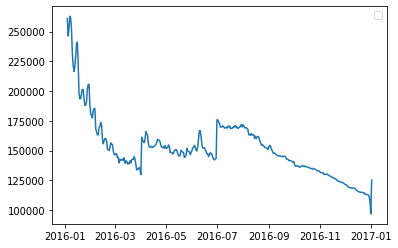

In [3]:
# Formatting price and date columns from calendar file
calendar["date"] = pd.to_datetime(calendar["date"], format='%Y-%m-%d')
calendar["price"] = calendar["price"].str.replace("$", "")
calendar["price"] = calendar["price"].str.replace(",", "")
calendar['price'] = pd.to_numeric(calendar['price'])
calendar = calendar.fillna(calendar.groupby(['listing_id']).transform('mean'))
calendar['Sales'] = np.where(calendar['available']=='f', calendar['price'] , 0)
#calendar.head()

# Calculating the actual sales perc for each listing in 2016
revlisting = calendar[['listing_id', 'price', 'Sales']].groupby('listing_id').sum().reset_index()
revlisting['Sales_perc'] = revlisting['Sales']/revlisting['price']
revlisting = revlisting[['listing_id', 'Sales_perc']]
revlisting = revlisting.fillna(0)

# Vicusalizing Sales trendline across 2016
revTimeline = calendar[['date', 'price', 'Sales']].groupby('date').sum().reset_index()

print("Trend of Bookings% in 2016 has been declining")
# Plotting daily sales
plt.plot(revTimeline['date'], revTimeline['Sales'])
plt.legend()
plt.show()



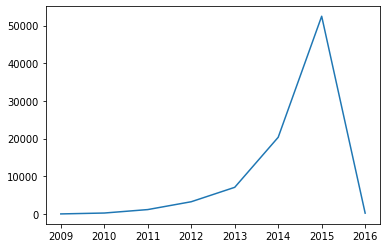

In [4]:
# Plotting no. of reviews per year

reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')
reviews['Year'] = reviews['date'].dt.year
reviews_20152016 = reviews[reviews['Year']>=2015]
reviews_20152016 = reviews_20152016[['listing_id', 'comments']].groupby('listing_id').count().reset_index()
reviews_20152016 = reviews_20152016.rename(columns={'comments':'tot_num_reviews_201516'})

reviewstim = reviews[['Year', 'comments']].groupby('Year').count().reset_index()
plt.plot(reviewstim['Year'], reviewstim['comments'])
plt.show()


 The number of reviews peaked in 2015 compared to other years

In [5]:
### Formatting columns in listings dataset to convert them to numeric

listings["price"] = listings["price"].str.replace("$", "")
listings["price"] = listings["price"].str.replace(",", "")
listings['price'] = pd.to_numeric(listings['price'])
listings["host_response_rate"] = listings["host_response_rate"].str.replace("%", "")
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'])
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'], format='%Y-%m-%d')
listings['first_review'] = pd.to_datetime(listings['first_review'], format='%Y-%m-%d')
calendar["date"] = pd.to_datetime(calendar["date"], format='%Y-%m-%d')
listings['age'] = (listings['last_scraped'] - listings['first_review']).dt.days
#listings.head()

In [6]:
### Merging reviews and bookings information to listings

MasterData = listings.merge(reviews_20152016, how = 'left', left_on='id', right_on='listing_id')
MasterData = MasterData.merge(revlisting, how = 'left', left_on='id', right_on='listing_id')

dums1 = pd.get_dummies(MasterData['room_type'])
MasterData = pd.concat([MasterData, dums1], axis=1)

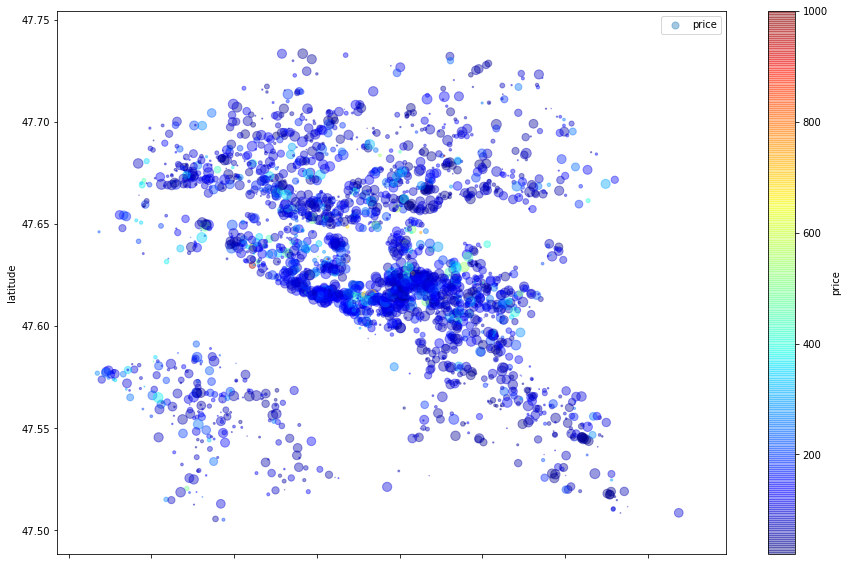

In [7]:
"""Plotting properties based on latitude and longitude
Color scale represents price
Size of bubble represents Booking % in 2016
"""

datageo = MasterData[MasterData['city']=='Seattle']
datageo.plot(kind="scatter", x="longitude", y="latitude",
    s=datageo['Sales_perc']*100, label="price",
    c="price", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(15,10),
)
plt.legend()
plt.show()

Properties with higher price has lower booking rates

### Counting Null values in columns

In [8]:
MasterData.isnull().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_

### Selecting model variables

In [9]:
"""Define X and y varibles for our model"""

dep_var = 'price'
SL_vars = [ 'host_total_listings_count',  'accommodates', 'bathrooms', 'bedrooms', 'host_response_rate', \
           'Entire home/apt', 'Shared room', \
           'review_scores_value', 'reviews_per_month', 'guests_included', 'Sales_perc' ]

## Fill null values with zero
Model_Data = MasterData
Model_Data = Model_Data.fillna(0)

print("The shape of the Modeling dataset is ", Model_Data.shape)

The shape of the Modeling dataset is  (3818, 100)


Text(0, 0.5, 'Avg. Price')

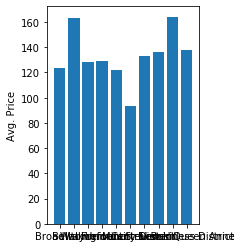

In [10]:
mdx1 = Model_Data[['neighbourhood_cleansed', 'price', 'number_of_reviews', 'review_scores_rating']].groupby('neighbourhood_cleansed').mean().reset_index()
mdx2 = Model_Data[['neighbourhood_cleansed', 'square_feet']].groupby('neighbourhood_cleansed').count().reset_index()
mdx1 = mdx1.merge(mdx2, how='left', on='neighbourhood_cleansed')
mdx3 = mdx1.sort_values(by='square_feet', ascending=False)[:10]

plt.subplot(1, 2, 1)
plt.rcParams["figure.figsize"] = (30, 10)
plt.bar(mdx3['neighbourhood_cleansed'], mdx3['price'])
plt.ylabel('Avg. Price')

#### Distribution of Price 

Mean of Price is :  127.97616553169199
Median of Price is :  100.0
Mode of Price is :  0    150.0
dtype: float64


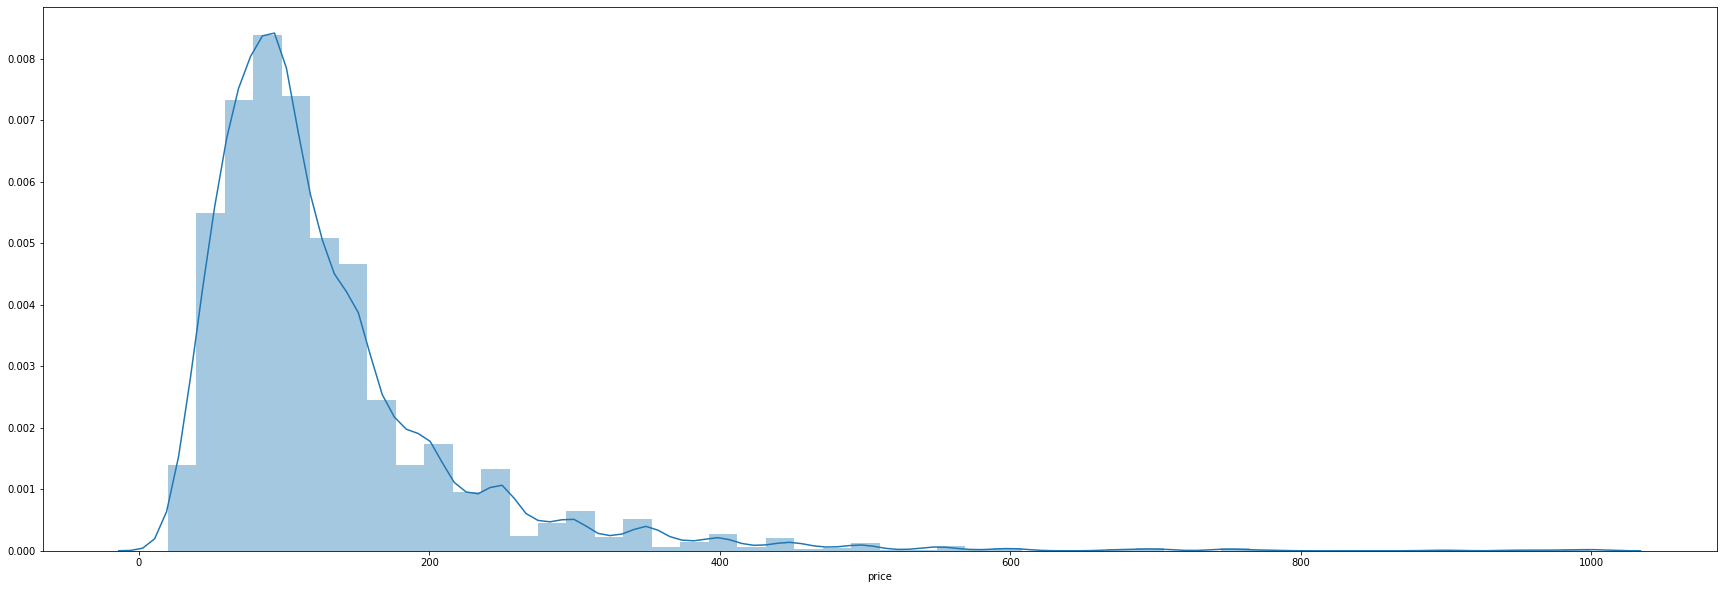

In [11]:
sns.distplot(Model_Data[dep_var])
print("Mean of Price is : ", Model_Data[dep_var].mean())
print("Median of Price is : ", Model_Data[dep_var].median())
print("Mode of Price is : ", Model_Data[dep_var].mode())

Text(0.5, 1.0, 'Price vs. Guests included')

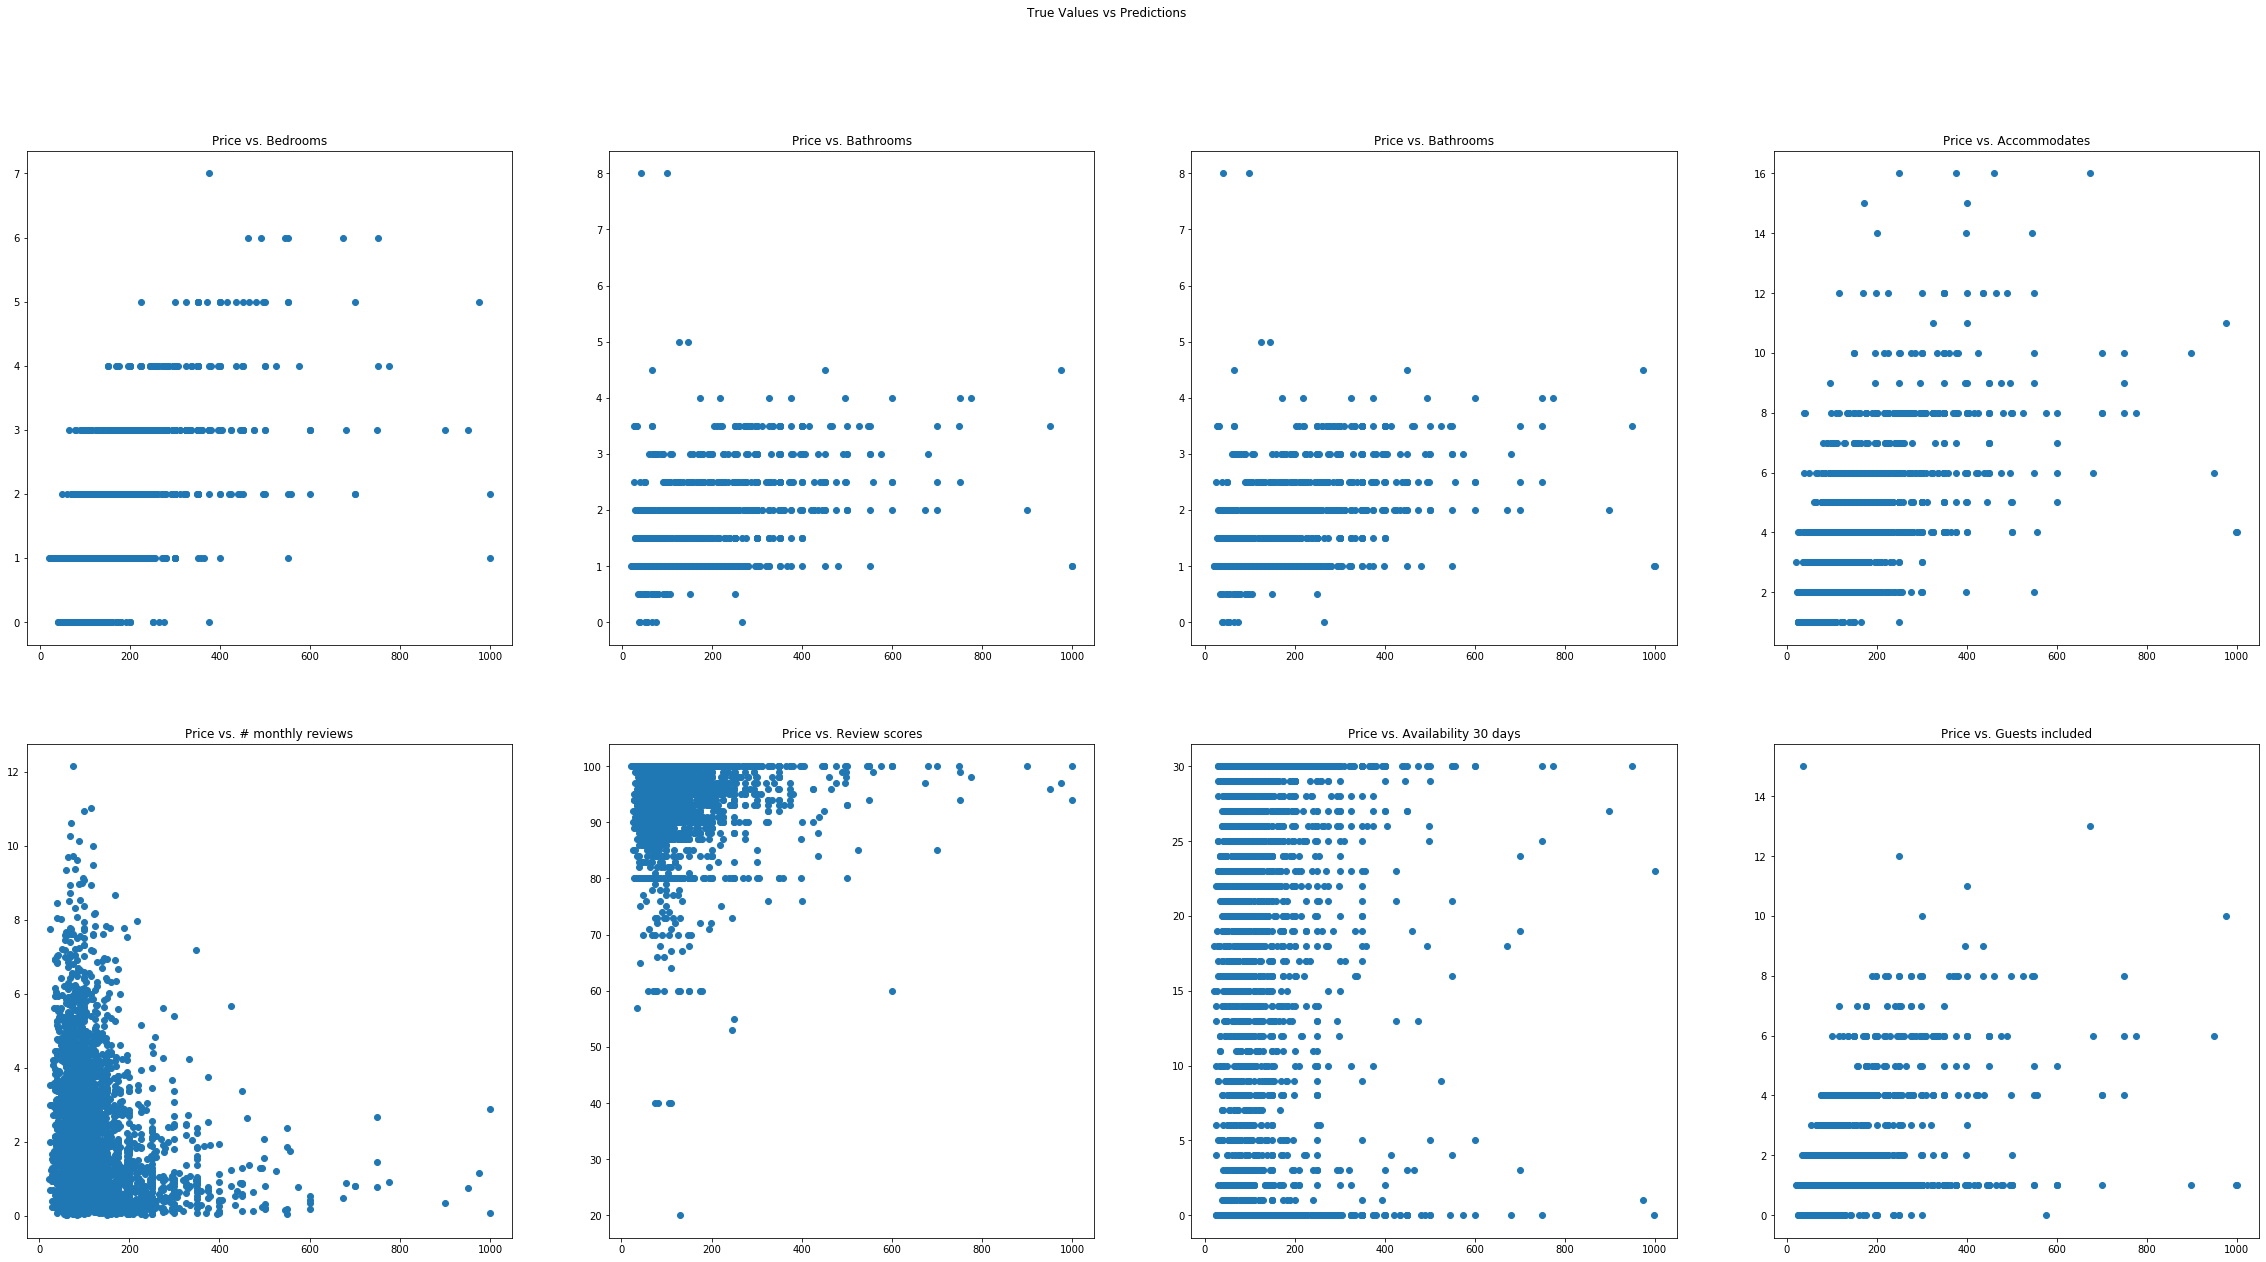

In [23]:
### Price vs Independent variables scayyer plots

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(40, 20))
fig.suptitle('X vs Y')

ax1.scatter(listings['price'], listings['bedrooms'])
ax1.set_title('Price vs. Bedrooms')

ax2.scatter(listings['price'], listings['bathrooms'])
ax2.set_title('Price vs. Bathrooms')

ax3.scatter(listings['price'], listings['bathrooms'])
ax3.set_title('Price vs. Bathrooms')

ax4.scatter(listings['price'], listings['accommodates'])
ax4.set_title('Price vs. Accommodates')

ax5.scatter(listings['price'], listings['reviews_per_month'])
ax5.set_title('Price vs. # monthly reviews')

ax6.scatter(listings['price'], listings['review_scores_rating'])
ax6.set_title('Price vs. Review scores')

ax7.scatter(listings['price'], listings['availability_30'])
ax7.set_title('Price vs. Availability 30 days')

ax8.scatter(listings['price'], listings['guests_included'])
ax8.set_title('Price vs. Guests included')

In [13]:
"""Filtering out till 99% quartiles of Price """

q = Model_Data[dep_var].quantile(0.99)
Model_Data = Model_Data[Model_Data[dep_var]<=q]
Model_Data = Model_Data[Model_Data[dep_var]>0]


### Correlation plot

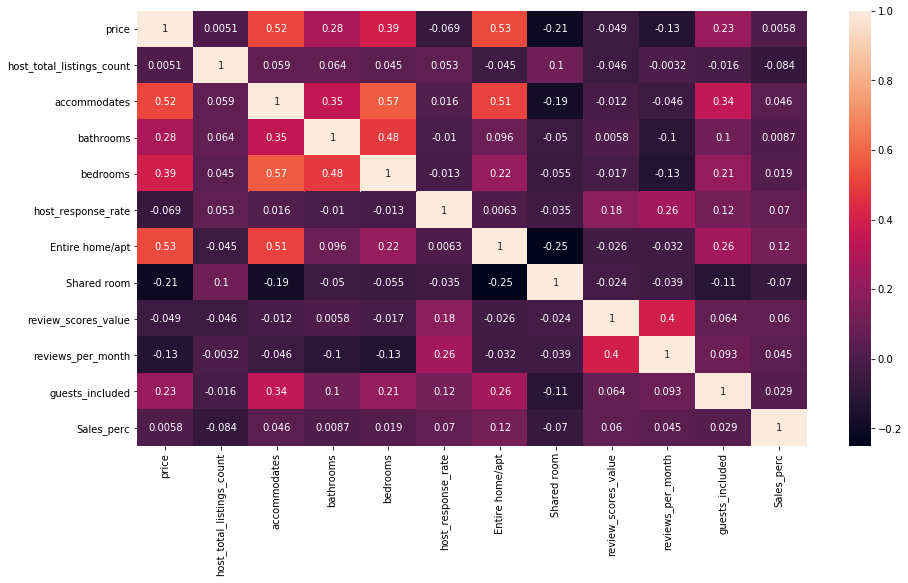

In [14]:
"""Correlation matrix for the data"""

corr = Model_Data[[dep_var] + SL_vars ].corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
#Model_Data.columns

In [15]:
print("There are ", Model_Data.shape[0], 'rows in the dataset.')
print("There are ", Model_Data.shape[1], 'columns in the dataset.')

There are  3780 rows in the dataset.
There are  100 columns in the dataset.


### Linear Regression model

In [16]:
X_SL = Model_Data[SL_vars]
y = Model_Data[dep_var]

scaler = MinMaxScaler(feature_range=(0, 1))
Test = scaler.fit_transform(X_SL)
Test = X_SL
X_SL = X_SL.fillna(0)

y = np.log(y)
y = y.replace([np.inf, -np.inf],0)
y = y.fillna(0)

# #Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_SL, y, test_size=0.2, random_state=42)


lm_model = LinearRegression(normalize=False) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train) 


### Model Results and validation

In [17]:
### Model results are validated on the Test set using R2 and RMSE

print("The Train R2 is : ", r2_score(y_train, y_train_preds))
print("The Test R2 is : ", r2_score(y_test, y_test_preds))
print("Train RMSE : ",(np.sqrt(mean_squared_error(y_train, y_train_preds))))
print("Test RMSE : ",(np.sqrt(mean_squared_error(y_test, y_test_preds))))

The Train R2 is :  0.6127665750492175
The Test R2 is :  0.6455294301172081
Train RMSE :  0.3345241589806647
Test RMSE :  0.3263625368878889


In [18]:
### Model coefficients

coef_dict = dict(zip(SL_vars, lm_model.coef_))
coef_dict

{'host_total_listings_count': 0.0006736440868440839,
 'accommodates': 0.05714413284687769,
 'bathrooms': 0.08175953157994799,
 'bedrooms': 0.1334105242716268,
 'host_response_rate': -0.001629147944575825,
 'Entire home/apt': 0.47169630320540373,
 'Shared room': -0.43270651028444934,
 'review_scores_value': 0.0017666015313560954,
 'reviews_per_month': -0.022154134085562965,
 'guests_included': 0.01569514170201777,
 'Sales_perc': -0.10085006783204072}

In [19]:
"""Testing for significance of independent variables"""
mod = sm.OLS(y,X_SL)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

host_total_listings_count     3.731278e-01
accommodates                  3.773023e-02
bathrooms                    1.580616e-145
bedrooms                      1.181568e-07
host_response_rate           2.210405e-130
Entire home/apt              3.341193e-128
Shared room                   1.339314e-03
review_scores_value          7.257395e-116
reviews_per_month             8.594834e-03
guests_included               1.077242e-06
Sales_perc                    4.423079e-32
Name: P>|t|, dtype: float64

### Reviews of properties in Seattle

In [20]:
"""Creating a wordcloud from comments in reviews dataset"""

reviews1 = reviews.merge(listings[['id', 'property_type', 'market']], how='left', left_on='listing_id', right_on='id').reset_index()

def wclouds(x, stpwrds):

    text = " ".join(str(review) for review in x)
    stopwords = set(STOPWORDS)
    stopwords.update(stpwrds)

    plt.subplots(figsize=(25,15))
    wordcloud = WordCloud(
                            stopwords=stopwords,                      
                            background_color='white',
                            width=1080,
                            height=1080
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


reviews1.property_type.unique()

array(['Apartment', 'House', 'Townhouse', 'Condominium', 'Loft',
       'Bungalow', 'Cabin', 'Bed & Breakfast', 'Boat', 'Other',
       'Camper/RV', 'Treehouse', 'Tent', 'Dorm', 'Chalet', 'Yurt'],
      dtype=object)

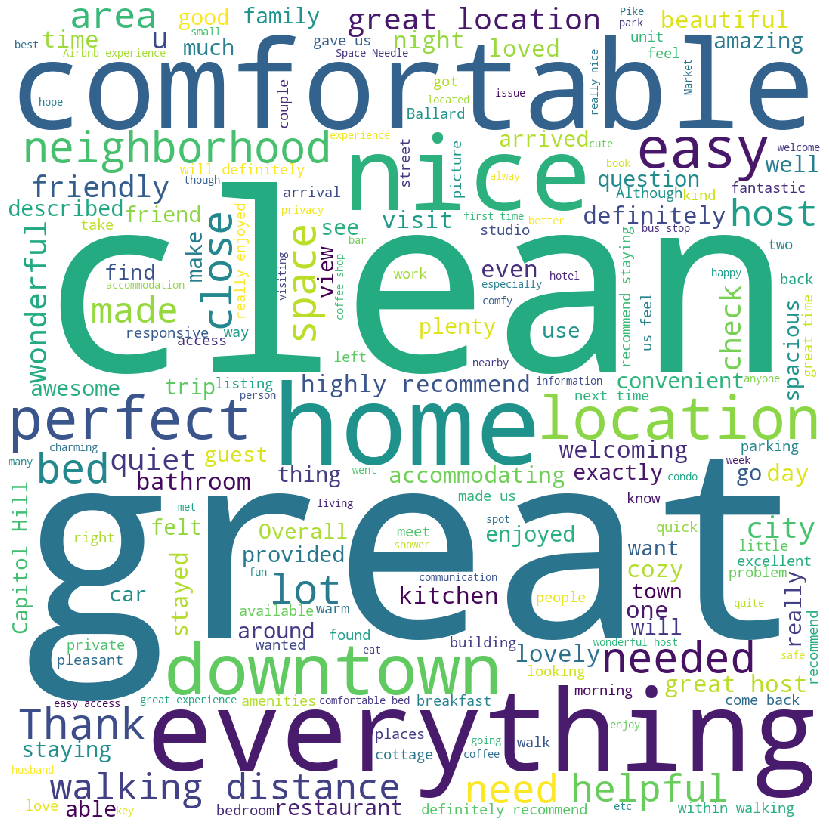

In [21]:
reviews_temp = reviews1[reviews1['market'].isin(['Seattle'])]

### Define words which should not apper in wordcloud
wclouds(reviews_temp.comments, ['Seattle', 'Boston', 'stay', 'place', 'room', 'apartment', 'house'])